# Projet n°6: Classifiez automatiquement des biens de consommations 
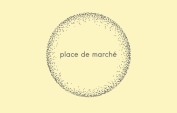

## I. Traitement des données textes

### Import des librairies et packages

In [1]:
#pip install wordcloud

In [2]:
#!pip install fasttext

In [3]:
#import fasttext
#Ne fonctionne pas

In [4]:
#nltk.download()

In [5]:
import string
import re

import nltk
from nltk.probability import FreqDist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from PIL import Image

from sklearn import feature_extraction as fe
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [6]:
#Suppression des warnings
import warnings
warnings.filterwarnings("ignore")

### Découverte des données

In [7]:
data = pd.read_csv('flipkart.csv')

In [8]:
data.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
438,ee78c1e94bdc217d1d0eaef5c567417a,2016-06-16 08:51:06 +0000,http://www.flipkart.com/budding-bees-printed-b...,Budding Bees Printed Baby Girl's Jumpsuit,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",JUMEGV7FGSSWHWCK,999.0,499.0,ee78c1e94bdc217d1d0eaef5c567417a.jpg,False,Specifications of Budding Bees Printed Baby Gi...,No rating available,No rating available,Budding Bees,"{""product_specification""=>[{""value""=>""1 Jumpsu..."
1026,3f97735a6c61a3587cefceaef36c280c,2016-03-03 06:06:42 +0000,http://www.flipkart.com/aroma-comfort-polyeste...,Aroma Comfort Polyester Green Self Design Eyel...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG72VZJDG4F29,999.0,899.0,3f97735a6c61a3587cefceaef36c280c.jpg,False,Key Features of Aroma Comfort Polyester Green ...,No rating available,No rating available,Aroma Comfort,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
585,a70ea60f971825b2eb57261029f317ec,2016-01-07 05:50:25 +0000,http://www.flipkart.com/flippd-fdrbb1614-fibre...,Flippd FDRBB1614 Fibre Analog Watch - For Men,"[""Watches >> Wrist Watches >> Flippd Wrist Wat...",WATEYUZXWKUESAYZ,750.0,750.0,a70ea60f971825b2eb57261029f317ec.jpg,True,Flippd FDRBB1614 Fibre Analog Watch - For Men...,3.6,3.6,NaN,"{""product_specification""=>[{""key""=>""Mechanism""..."
180,58d7fbbe6d306ecf16e0a7ac05b211d4,2015-12-01 12:40:44 +0000,http://www.flipkart.com/printland-pmr1332-cera...,Printland PMR1332 Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Printland...",MUGEACY8EWA937QD,650.0,299.0,58d7fbbe6d306ecf16e0a7ac05b211d4.jpg,False,Printland PMR1332 Ceramic Mug (350 g)\r\n ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
799,5188dd28a627807407d93549580afb74,2015-12-12 11:46:53 +0000,http://www.flipkart.com/rajrang-animal-cushion...,Rajrang Animal Cushions Cover,"[""Home Furnishing >> Cushions, Pillows & Cover...",CPCE8URTHJE6AK3N,2149.0,984.0,5188dd28a627807407d93549580afb74.jpg,False,Buy Rajrang Animal Cushions Cover at Rs. 984 a...,No rating available,No rating available,Rajrang,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [11]:
data["product_category_tree"].nunique()

642

In [10]:
data.isnull().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

### Observation des informations pour une entrée

In [12]:
data["product_category_tree"].iloc[215]

'["Kitchen & Dining >> Kitchen Tools >> Kitchen Implements >> Pizza Cutters >> King International Pizza Cutters"]'

In [13]:
data["product_url"].iloc[215]

'http://www.flipkart.com/king-international-ergonomic-design-long-gripped-handle-rolling-pizza-cutter/p/itmebdfu5qycht8g?pid=PACEBDFU4SN2D5SA'

In [14]:
data["product_specifications"].iloc[215]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"King International"}, {"key"=>"Used for", "value"=>"Cutting Pizza"}, {"key"=>"Handle Material", "value"=>"Plastic"}, {"key"=>"Blade Material", "value"=>"Stainless Steel"}, {"key"=>"Model Number", "value"=>"KI-PIZ-CTR"}, {"key"=>"Thumb Guard", "value"=>"Yes"}, {"key"=>"Shade", "value"=>"Steel"}, {"key"=>"Type", "value"=>"Rolling"}, {"key"=>"Model Name", "value"=>"Ergonomic Design with Long Gripped Handle"}, {"key"=>"Suitable for", "value"=>"12 Inch Pizza, 6 Inch Pie"}, {"key"=>"Grip Type", "value"=>"Soft Grip"}, {"key"=>"Color", "value"=>"Steel, White, Red"}, {"key"=>"Sales Package", "value"=>"1 Pizza cutter"}, {"key"=>"Pack of", "value"=>"1"}, {"key"=>"Diameter", "value"=>"8.5 inch"}, {"key"=>"Weight", "value"=>"40 g"}, {"key"=>"Height", "value"=>"2 inch"}, {"key"=>"Width", "value"=>"8.5 inch"}, {"key"=>"Depth", "value"=>"2 inch"}, {"key"=>"Dishwasher Safe", "value"=>"Yes"}]}'

In [15]:
data["description"].iloc[215]

'King International Ergonomic Design with Long Gripped Handle Rolling Pizza Cutter (Stainless Steel Pack of 1)\r\n                         Price: Rs. 199\r\n\t\t\t\t\r\n\t\t\t"Stop fights among friends over the last slice of pizza using this pizza cutten from Fab Kitchen. The suttle color allows it to blend in perfectly with your other kitchen cutlery. The razor sharp stainless steel blade allows it to instantly cut up food slices. Short Description\r\n* Material: Stainless Steel & Plastic\r\n* Color: Red, White and Steel\r\n* Freezer Safe: Yes\r\n* Dishwasher Safe: Yes\r\n* Pizza Cutter Length: 8 inches (20 cm)\r\n* Quantity: 1 Piece (Pizza Cutter)"\r\n"Stop fights among friends over the last slice of pizza using this pizza cutten from Fab Kitchen. The suttle color allows it to blend in perfectly with your other kitchen cutlery. The razor sharp stainless steel blade allows it to instantly cut up food slices. Short Description\r\n* Material: Stainless Steel & Plastic\r\n* Color: Red, W

In [16]:
data["image"].iloc[215]

'91a5328e7235424885d271dfa0959eeb.jpg'

In [17]:
data["product_specifications"].iloc[215]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"King International"}, {"key"=>"Used for", "value"=>"Cutting Pizza"}, {"key"=>"Handle Material", "value"=>"Plastic"}, {"key"=>"Blade Material", "value"=>"Stainless Steel"}, {"key"=>"Model Number", "value"=>"KI-PIZ-CTR"}, {"key"=>"Thumb Guard", "value"=>"Yes"}, {"key"=>"Shade", "value"=>"Steel"}, {"key"=>"Type", "value"=>"Rolling"}, {"key"=>"Model Name", "value"=>"Ergonomic Design with Long Gripped Handle"}, {"key"=>"Suitable for", "value"=>"12 Inch Pizza, 6 Inch Pie"}, {"key"=>"Grip Type", "value"=>"Soft Grip"}, {"key"=>"Color", "value"=>"Steel, White, Red"}, {"key"=>"Sales Package", "value"=>"1 Pizza cutter"}, {"key"=>"Pack of", "value"=>"1"}, {"key"=>"Diameter", "value"=>"8.5 inch"}, {"key"=>"Weight", "value"=>"40 g"}, {"key"=>"Height", "value"=>"2 inch"}, {"key"=>"Width", "value"=>"8.5 inch"}, {"key"=>"Depth", "value"=>"2 inch"}, {"key"=>"Dishwasher Safe", "value"=>"Yes"}]}'

In [18]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
list_spec = tokenizer.tokenize(data["product_specifications"].iloc[215])
list_spec[:10]

['product_specification',
 'key',
 'Brand',
 'value',
 'King',
 'International',
 'key',
 'Used',
 'for',
 'value']

In [19]:
list_desc = tokenizer.tokenize(data["description"].iloc[215])
list_desc[:10]

['King',
 'International',
 'Ergonomic',
 'Design',
 'with',
 'Long',
 'Gripped',
 'Handle',
 'Rolling',
 'Pizza']

In [20]:
ps = nltk.PorterStemmer()

for w in list_desc[:10]:
    print(w, " : ", ps.stem(w))

King  :  king
International  :  intern
Ergonomic  :  ergonom
Design  :  design
with  :  with
Long  :  long
Gripped  :  grip
Handle  :  handl
Rolling  :  roll
Pizza  :  pizza


In [21]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)


# 1. Init Lemmatizer
lemmatizer = nltk.WordNetLemmatizer()

# 2. Lemmatization d'une liste de mots avec le tag POS approprié
print([lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w)) for w in list_desc[:10]])

['king', 'international', 'ergonomic', 'design', 'with', 'long', 'grip', 'handle', 'roll', 'pizza']


In [22]:
#Exemple avec une phrase simple
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenizer.tokenize("Rico's child is playing soccer with his feet ;) ")])

['Rico', 's', 'child', 'be', 'play', 'soccer', 'with', 'his', 'foot']


----

## Traitement des données textuelles du dataset
#### Extraction des catégories

In [23]:
#Traitement des catégories
def split_categ(categ, level):
    categ = categ.replace("[\"", "").replace("\"]", "")
    cat = categ.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categ_1(categ):
    return split_categ(categ,0)
def split_categ_2(categ):
    return split_categ(categ,1)
def split_categ_3(categ):
    return split_categ(categ,2)

def detail_categ(dataframe):
    dataframe['categ_principale'] = dataframe['product_category_tree'].apply(split_categ_1)
    dataframe['categ_secondaire'] = dataframe['product_category_tree'].apply(split_categ_2)
    dataframe['categ_tertiaire'] = dataframe['product_category_tree'].apply(split_categ_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [24]:
df = detail_categ(data.fillna("null"))

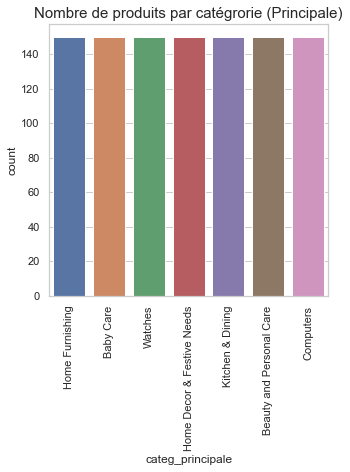

In [140]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.countplot(x='categ_principale', data = df)
ax.set_title("Nombre de produits par catégrorie (Principale)", size=15)
ax.set_xticklabels(labels=df['categ_principale'].unique(), rotation=90)
plt.savefig("count.png", bbox_inches="tight", transparent=True)
plt.show()

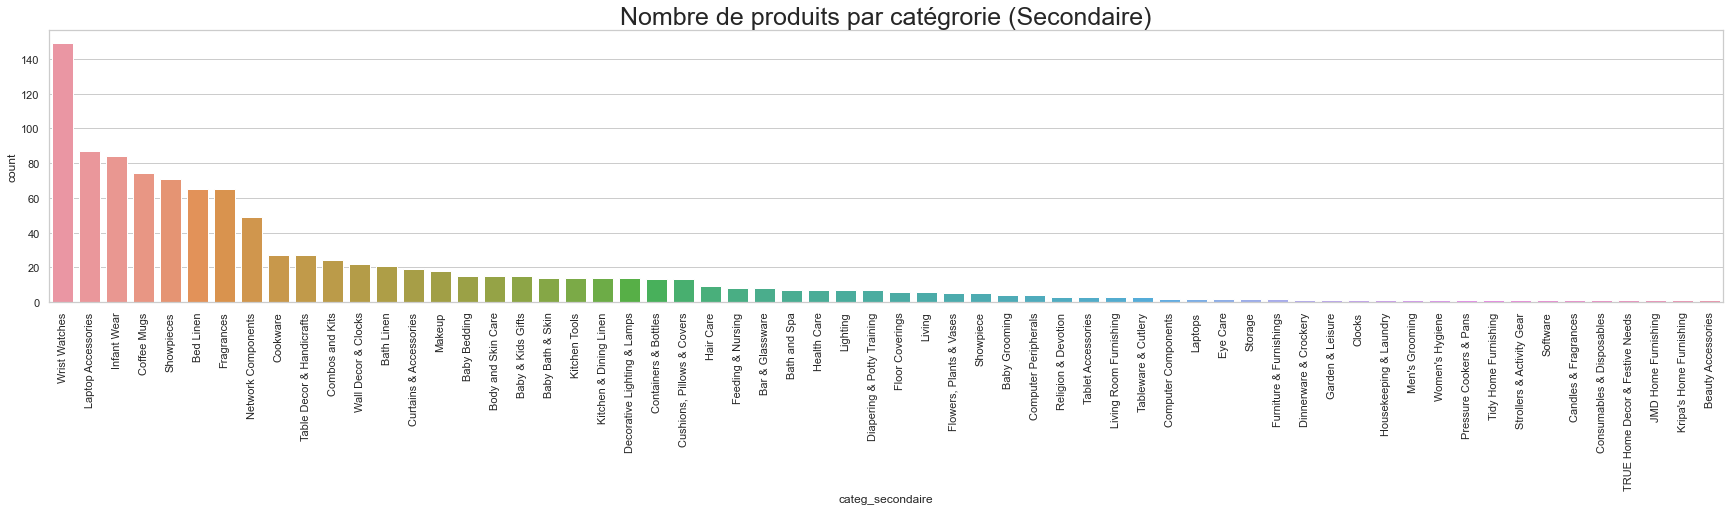

In [139]:
fig, ax = plt.subplots(figsize=(30,5))
ax = sns.countplot(x='categ_secondaire', data = df , order = df['categ_secondaire'].value_counts().index )
ax.set_title("Nombre de produits par catégrorie (Secondaire)", size = 25)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.savefig("count_sec.png", bbox_inches="tight", transparent=True)
plt.show()

In [25]:
df.sample()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categ_principale,categ_secondaire,categ_tertiaire
359,4b0e6f200426b1db8824b2ca0c59ecfa,2015-12-01 06:13:00 +0000,http://www.flipkart.com/park-avenue-believe-sp...,"Park Avenue Believe Spray ,Four Seasons EDP Co...",CAGE9ABAW2FEMYCG,389.0,389.0,4b0e6f200426b1db8824b2ca0c59ecfa.jpg,False,"Flipkart.com: Buy Park Avenue Believe Spray ,F...",No rating available,No rating available,null,"{""product_specification""=>[{""key""=>""Number of ...",Beauty and Personal Care,Fragrances,Deodorants


In [26]:
df["categ_principale"].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [27]:
df["categ_secondaire"].unique()

array(['Curtains & Accessories', 'Baby Bath & Skin', 'Bed Linen',
       'Wrist Watches', 'Living Room Furnishing', 'Bath Linen',
       'Candles & Fragrances', 'Tableware & Cutlery', 'Lighting',
       'JMD Home Furnishing', 'Infant Wear', "Kripa's Home Furnishing",
       'Hair Care', 'Coffee Mugs', 'Network Components',
       'Tablet Accessories', 'Cookware', 'Laptop Accessories', 'Makeup',
       'Combos and Kits', 'Feeding & Nursing', 'Baby Bedding',
       'Kitchen & Dining Linen', 'Containers & Bottles',
       'Consumables & Disposables', 'Wall Decor & Clocks',
       'Table Decor & Handicrafts', 'Flowers, Plants & Vases', 'Software',
       'Showpieces', 'Furniture & Furnishings',
       'Decorative Lighting & Lamps', 'Baby Grooming',
       'Computer Peripherals', 'Cushions, Pillows & Covers', 'Storage',
       'Health Care', 'Body and Skin Care', 'Kitchen Tools',
       'TRUE Home Decor & Festive Needs', 'Living', 'Showpiece',
       'Bar & Glassware', 'Fragrances', "Women'

In [28]:
df[df['categ_secondaire'] == 'Beauty Accessories']

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categ_principale,categ_secondaire,categ_tertiaire
976,fa2e5f01bbb642c49e4b2e19d2b39dcf,2016-05-19 02:12:59 +0000,http://www.flipkart.com/lottie-london-make-me-...,LOTTIE LONDON MAKE ME BLUSH,BAREGTPNZNHZHA8Z,850.0,765.0,fa2e5f01bbb642c49e4b2e19d2b39dcf.jpg,False,LOTTIE LONDON MAKE ME BLUSH (Pack of 1) Price:...,No rating available,No rating available,LOTTIE LONDON,"{""product_specification""=>[{""key""=>""Brush Type...",Beauty and Personal Care,Beauty Accessories,Makeup Accessories


On observe que pour certaines catégories secondaires, le nombre d'élément peut être très limité.  
Il sera impossible pour notre algorithme d'apprendre avec si peu d'élément.  
  
Nous nous contenterons de classer les produits selon la catégorie principale.

In [29]:
df = df.groupby(['categ_principale']).agg(description=('description',lambda x: ' '.join(x)),
                                              name=('product_name',lambda x: ' '.join(x)),
                                              brand=('brand',lambda x: ' '.join(x)),
                                              spec=('product_specifications',lambda x: ' '.join(x)))

In [30]:
df

,description,name,brand,spec
categ_principale,,,,
Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas Cotton Bath Towel Eurospa Cotton Terr...,Sathiyas Eurospa Mom and Kid Mom and Kid KOHL ...,"{""product_specification""=>[{""key""=>""Machine Wa..."
Beauty and Personal Care,Key Features of Burt s Bees Hair Repair Shea A...,Burt s Bees Hair Repair Shea And Grapefruit De...,Burt s Bees Suave null RYTHMX RYTHMX Brillare ...,"{""product_specification""=>[{""key""=>""Hair Condi..."
Computers,"Key Features of D-Link DAP1320 QRS app(iOS,And...",D-Link DAP1320 RoQ Slim Multimedia 105key Flex...,D-Link RoQ JRB JRB JRB Eureka.in Filink FRENEM...,"{""product_specification""=>[{""key""=>""Wireless S..."
Home Decor & Festive Needs,Myesquire Ceramic Burner Pot Lemongrass Liquid...,Myesquire Ceramic Burner Pot Lemongrass Liquid...,Myesquire VarEesha Treasure @home Smart Wall G...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
Home Furnishing,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...,Elegance SANTOSH ROYAL FASHION Jaipur Print SA...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
Kitchen & Dining,Key Features of Dungri India Craft Ducjug010-d...,Dungri India Craft Ducjug010-ducgl012-2 Jug Gl...,Dungri India Craft BFT AKUP AKUP AKUP AKUP AKU...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
Watches,Maserati Time R8851116001 Analog Watch - For ...,Maserati Time R8851116001 Analog Watch - For ...,null null null null null null null null null n...,"{""product_specification""=>[{""key""=>""Chronograp..."


### Traitement des données (stopwords, tokenisation, lemmatisation)

On va créer la liste des stopwords que l'on veut mettre de côté

In [31]:
sw = set(nltk.corpus.stopwords.words('english'))
sw_p = set(['cm', 'id', '', 'inch', 'length', 'width', 'height', 'yes', 'set', 'dimension', 'size', 'weight', 'tg'
            'NUM', 'key', 'value', 'productspecification', 'color', 'feature', 'blue', 'yellow', 'red', 'brand', 'null', 'specification',
            'type', 'content', 'product', 'shuvampcftsetassorted', 'green', 'grey', 'also', 'le', 'price', 'r', 'ml',
            'sale', 'x', 'g', 'l', 'v', 'w', 'm', 'e', 'pa', 'gm', 'flipkart', 'n', 'mm', 'com', 'buy', 'shipping', 'package',
            'delivery', 'free', 'cash', 'shuvam20pcftsetassorted', 'warranty', 'model', 'guarantee', 'number', 'detail', 'pack',
            'use', 'f'])
punct = set(string.punctuation)
number = set(string.digits)
sw = set.union(sw, sw_p, number, punct)

In [32]:
def cleaning_text(colonne):
    
        
    #check si la colonne est vide
    if colonne.isnull().sum() > 0:
        colonne.fillna('null',inplace=True)
    
     
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    colonne = colonne.apply(lambda x: tokenizer.tokenize(x.lower()))
    
    # on ne conserve que les mots
    colonne = colonne.apply(lambda x: [re.sub('[^A-Za-z ]','', w) for w in x])
    #on "nettoie les espaces"
    colonne = colonne.apply(lambda x: [re.sub('\s+','', w) for w in x])
    
    
    lemmatizer = nltk.WordNetLemmatizer()
    colonne = colonne.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    #Elimination des stopwords
    colonne = colonne.apply(lambda x: [w for w in x if not w in sw])
    #Transformation des listes en string
    colonne = colonne.apply(lambda x: ' '.join(x))
    
    return colonne

In [33]:
df['description_clean'] = cleaning_text(df['description'])
df['name'] = cleaning_text(df['name'])
df['brand'] = cleaning_text(df['brand'])

In [34]:
df['words'] = df['description_clean'] + df['name'] + df['brand']

In [35]:
def clean_total(df):
    df.drop(columns=['uniq_id', 'crawl_timestamp', 'product_url', 'pid', 'retail_price', 'discounted_price', 'is_FK_Advantage_product',
                     'product_rating', 'overall_rating', 'product_specifications'], inplace=True)
    df.fillna("null ", inplace=True)
    df = detail_categ(df)
    for col in ["description", "product_name", "brand"]:
        df[col] = cleaning_text(df[col])
    df['words'] = df['description'] + " " + df['product_name'] + " " + df['brand']
    df.drop(columns=['categ_secondaire', 'categ_tertiaire'], inplace=True)
    return df

### Observation des fréquences d'occurence

In [36]:
def extract_freq(colonne):
    fdist = {}
    n = 0
    for i in colonne:
        f = FreqDist(word.lower() for word in tokenizer.tokenize(i))
        fdist[colonne.index[n]] = f
        n += 1
    return fdist


In [37]:
fdist = extract_freq(df['words'])

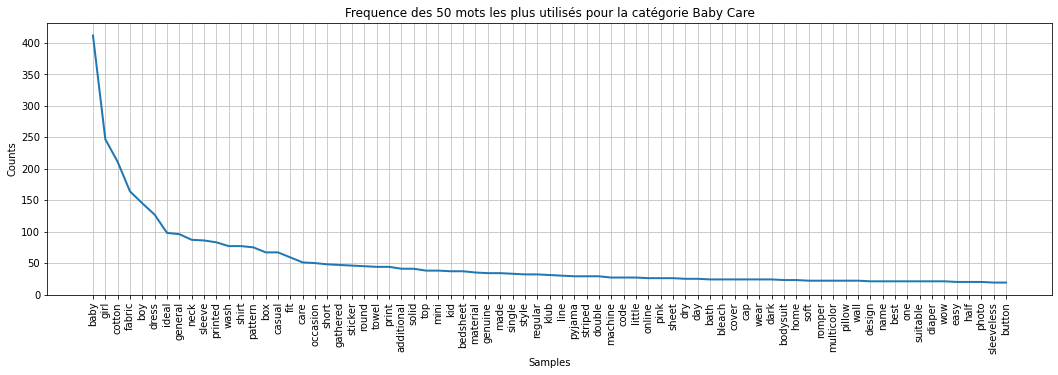

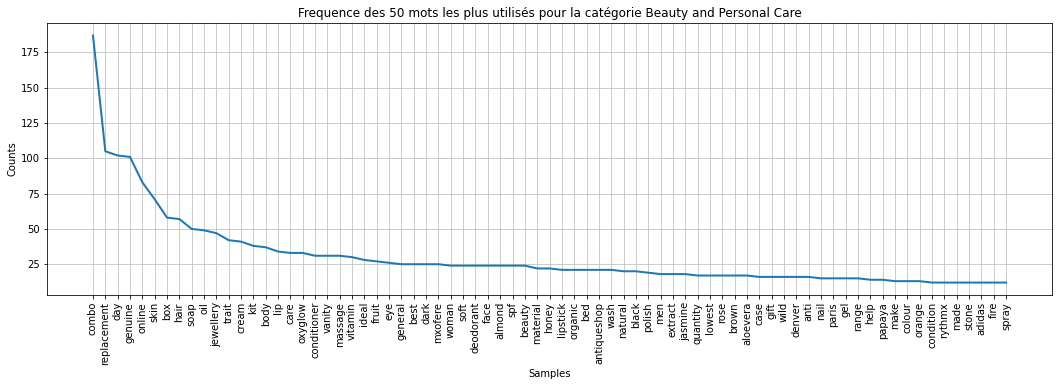

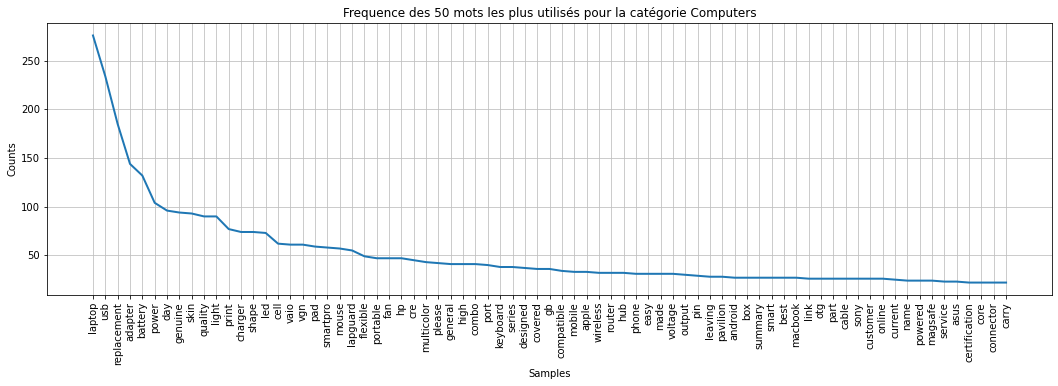

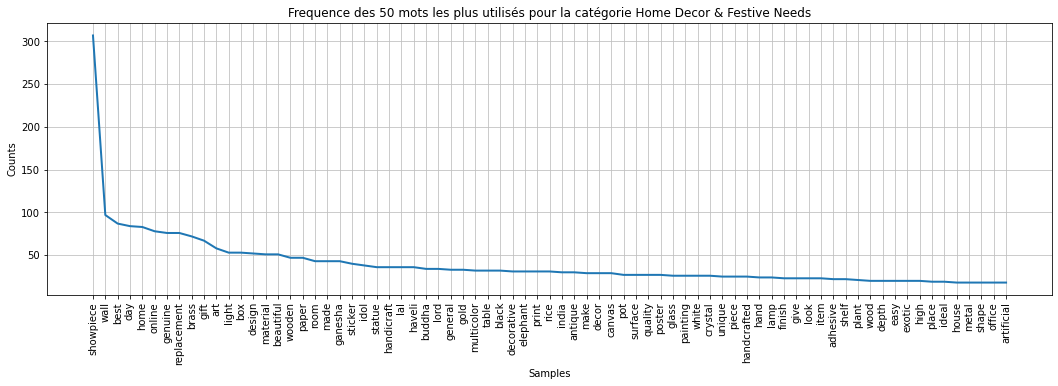

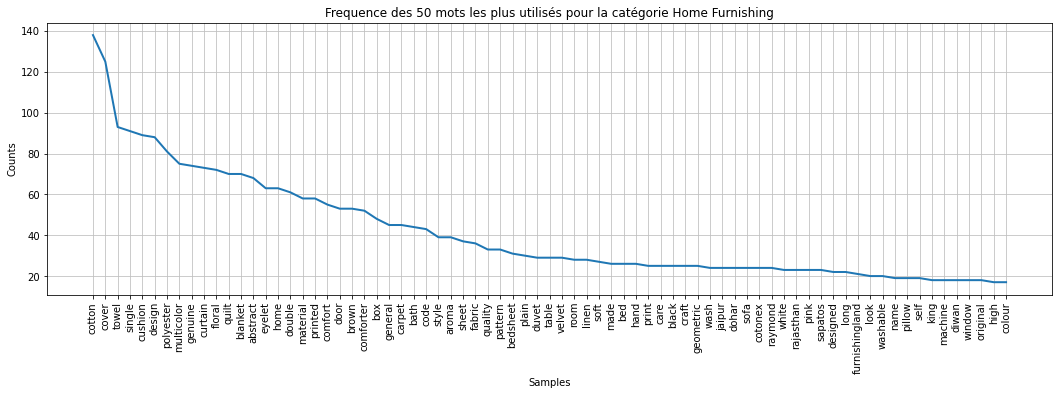

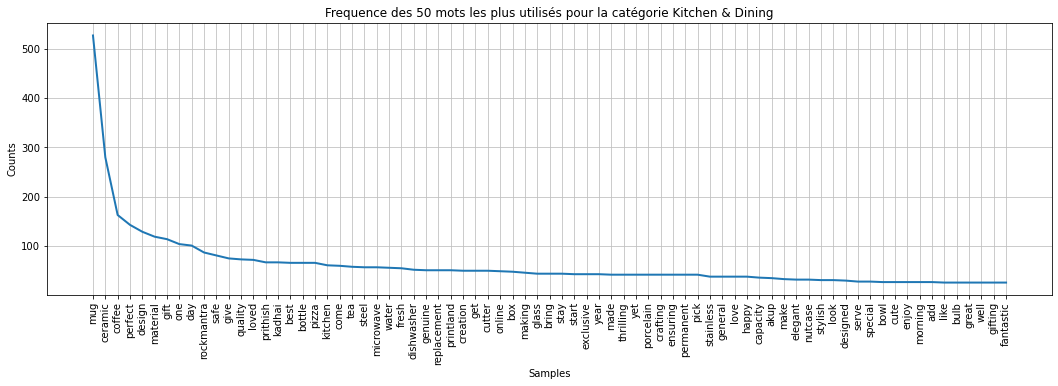

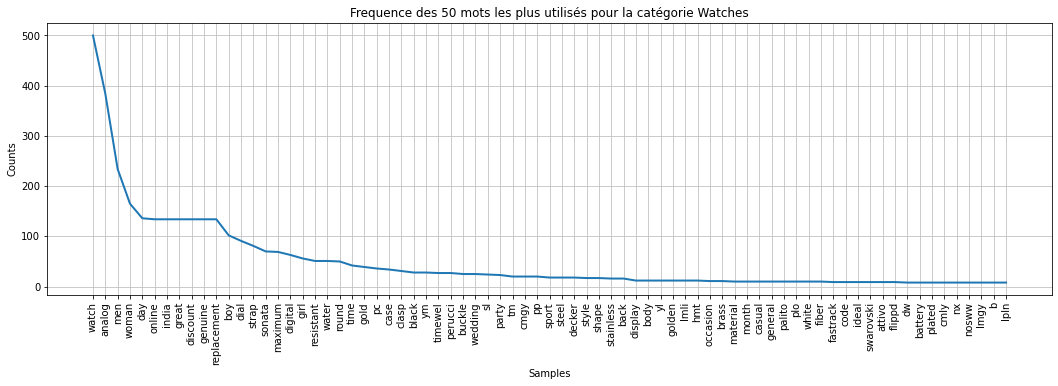

In [38]:
for k, v in fdist.items():
    plt.figure(figsize=(18, 5))
    v.plot(75, title='Frequence des 50 mots les plus utilisés pour la catégorie {}'.format(k))
    #plt.setp(ax.get_xticklabels(), rotation=45)
    plt.show()

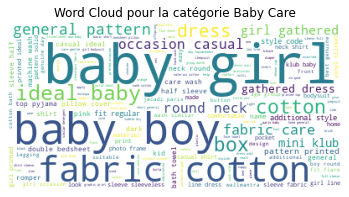

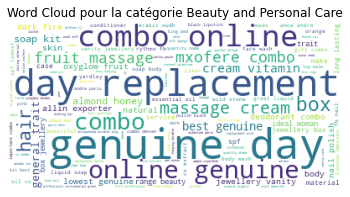

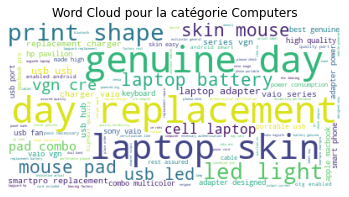

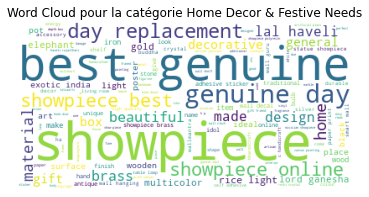

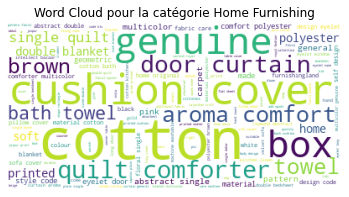

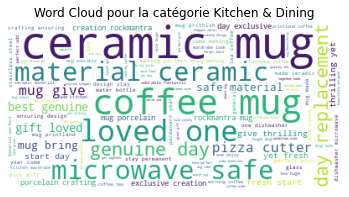

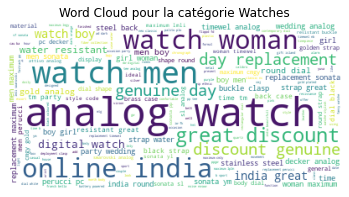

In [39]:
wordcloud = WordCloud(stopwords=sw, background_color="white")
i = 0
for k, v in df['words'].iteritems():
    
    wordcloud.generate(df['words'].iloc[i])
    plt.imshow(wordcloud)
    plt.title("Word Cloud pour la catégorie {}".format(k))
    plt.axis('off')
    i += 1
    plt.savefig("{}.png".format(k), transparent=True)
    plt.show()

### TF-IDF


In [40]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in nltk.RegexpTokenizer(doc)]

In [41]:
vectorizer = fe.text.TfidfVectorizer(stop_words=sw)
X = vectorizer.fit_transform(df['words'])
len(vectorizer.get_feature_names())

4655

In [42]:
X.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00349635, 0.00421204, 0.02097812, ..., 0.        , 0.        ,
         0.        ],
        [0.00320448, 0.        , 0.        , ..., 0.00193021, 0.00965104,
         0.01737187],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [43]:
transformation = []
for i, el  in enumerate(X.todense()[4,:].tolist()[0]):
    if el !=0:
        transformation.append((vectorizer.get_feature_names()[i], el))
pd.DataFrame(transformation, columns=['mot', 'tfidf']).sort_values(by='tfidf', ascending=False).head(10)

,mot,tfidf
150,cotton,0.318019
166,cushion,0.289063
725,towel,0.250731
164,curtain,0.237097
561,quilt,0.227353
647,single,0.209708
250,eyelet,0.204618
72,blanket,0.188723
527,polyester,0.186663
152,cover,0.170133


In [44]:
#vectorizer.vocabulary_

In [45]:
vectorizer_ngram = fe.text.TfidfVectorizer(ngram_range=(2,2), stop_words=sw)
X_ngram = vectorizer_ngram.fit_transform(df["description"])

In [46]:
#vectorizer_ngram.vocabulary_

### Topic Modeling 
#### LDA

In [47]:
tf_vectorizer = fe.text.CountVectorizer(max_df=0.95, min_df=2, stop_words=sw)
tf = tf_vectorizer.fit_transform(df['words'])

In [48]:
tf.todense()

matrix([[0, 0, 0, ..., 3, 1, 0],
        [1, 6, 0, ..., 0, 0, 2],
        [2, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 6],
        [0, 0, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [49]:
n_topics = 7
# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=7, random_state=0)

In [50]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
combo online skin hair soap oil jewellery trait cream kit
Topic 1:
mug ceramic coffee perfect gift safe give loved best bottle
Topic 2:
cotton pattern baby printed polyester single coffee towel abstract showpiece
Topic 3:
showpiece cotton home multicolor single wall towel best polyester online
Topic 4:
watch analog men woman online boy dial strap maximum digital
Topic 5:
baby girl cotton fabric boy neck printed wash pattern casual
Topic 6:
battery power skin print led cell pad flexible portable hp


In [51]:
def plot_top_words(model, feature_names, no_top_words, title):
    fig, axes = plt.subplots(2, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -no_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    #plt.savefig("{}.png".format(model), transparent=True)
    plt.show()

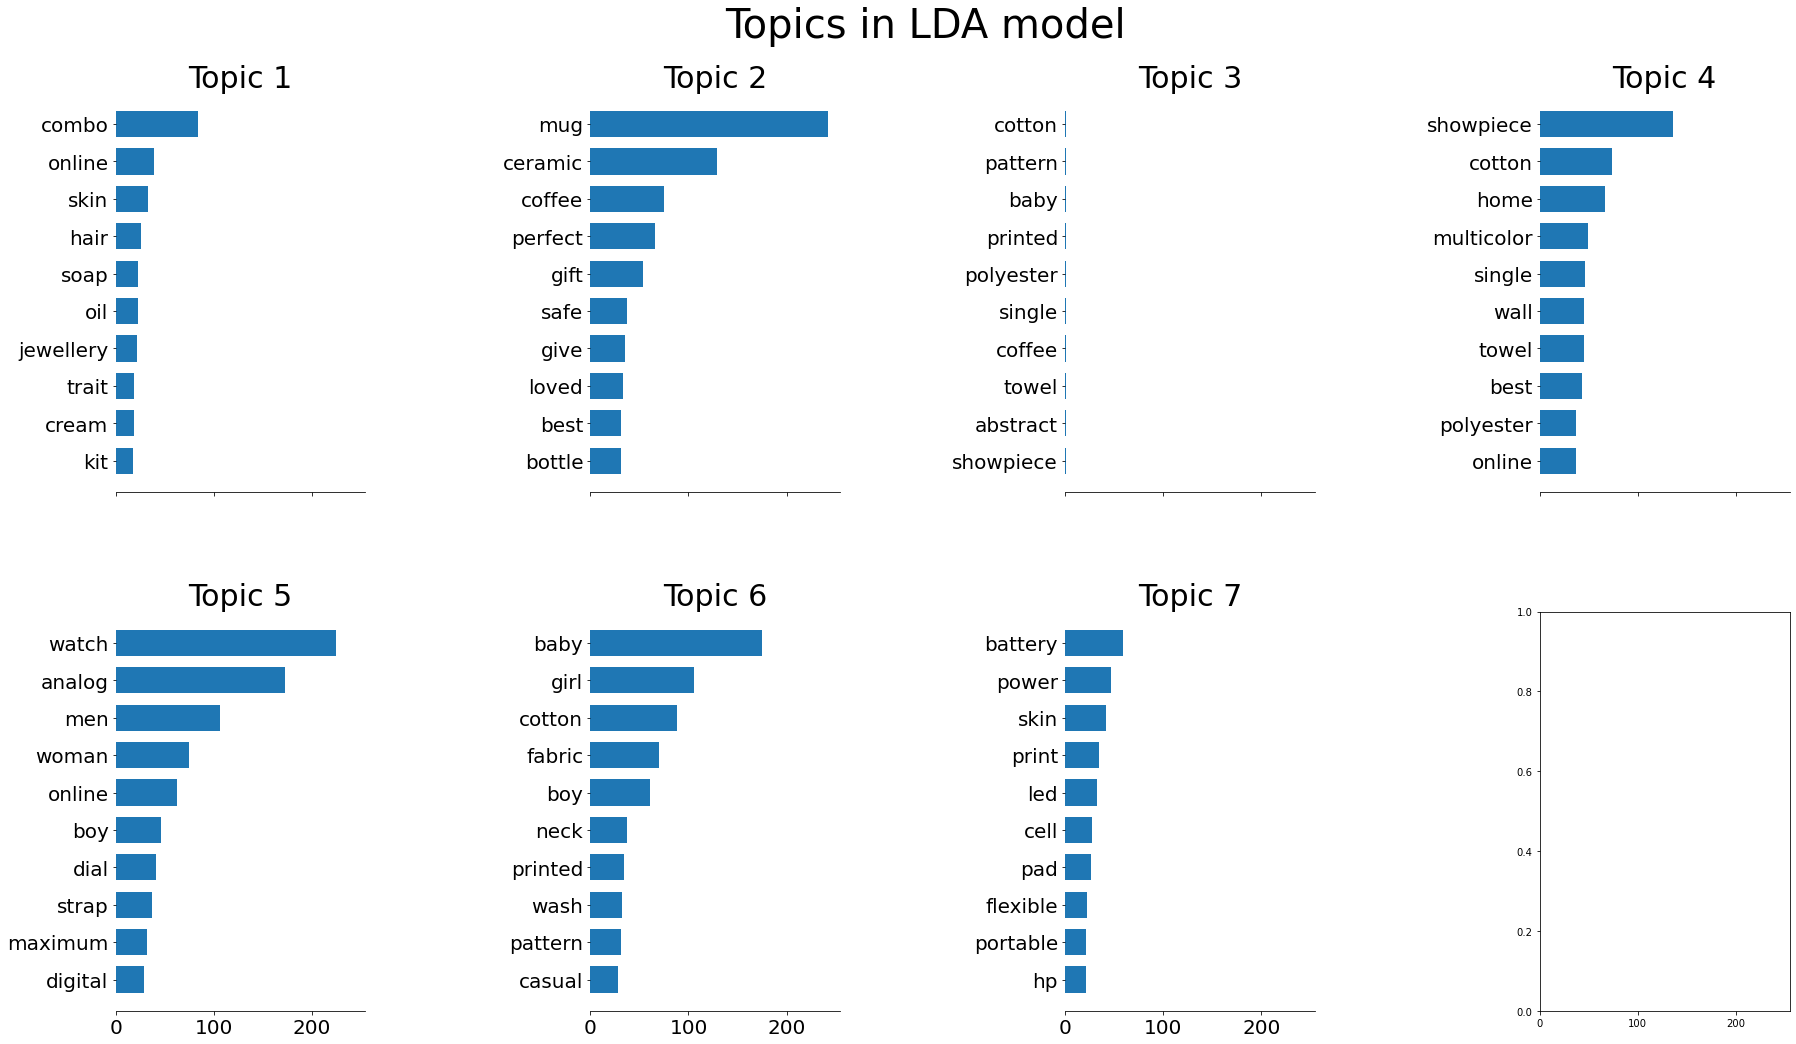

In [52]:
plot_top_words(lda, tf_vectorizer.get_feature_names(), no_top_words, "Topics in LDA model")

#### NMF

In [53]:
tfidf_vectorizer = fe.text.TfidfVectorizer(
    max_df=0.95, min_df=2, stop_words=sw
)
tfidf = tfidf_vectorizer.fit_transform(df['words'])

In [54]:
nmf = NMF(n_components=7, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)

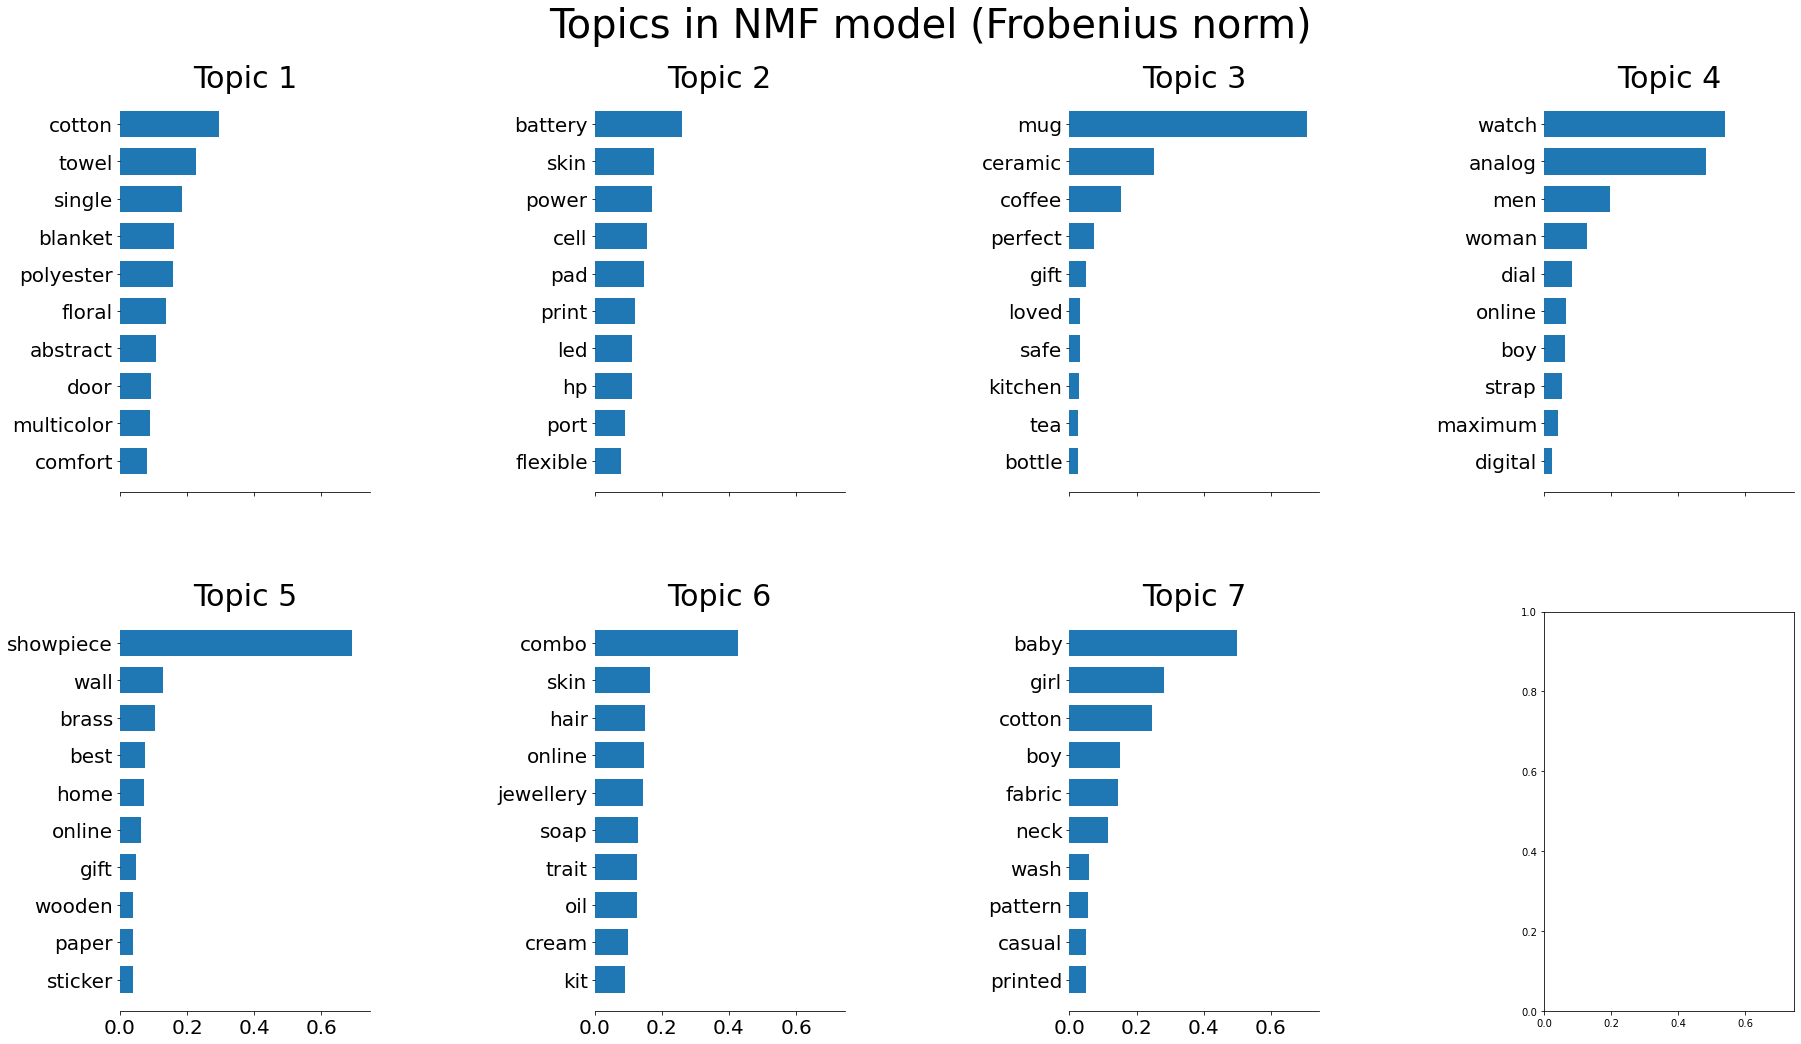

In [55]:
plot_top_words(nmf, tfidf_vectorizer.get_feature_names(), no_top_words, "Topics in NMF model (Frobenius norm)")

### Clustering (Application d'algorithme supervisé)
#### Naives Bayes (MNB)


In [56]:
train, test = train_test_split(data, random_state=9, test_size=0.20)

In [57]:
train_c, test_c = train.copy(), test.copy()

In [58]:
train_c = clean_total(train_c)
test_c = clean_total(test_c)

In [59]:
clean_total(train).to_csv('train.csv', index=False)
clean_total(test).to_csv('test.csv', index=False)

In [60]:
X_train = vectorizer.fit_transform(train_c['words'])
y_train = train_c['categ_principale']
X_test = vectorizer.transform(test_c['words'])
y_test = test_c['categ_principale']

In [61]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [62]:
y_pred_mnb = mnb.predict(X_test)

In [63]:
print('Accuracy sur le train set : ', accuracy_score(mnb.predict(X_train), y_train))
print('Accuracy sur le test set : ', accuracy_score(mnb.predict((X_test)), y_test))

Accuracy sur le train set :  0.9880952380952381
Accuracy sur le test set :  0.9047619047619048


In [64]:
print(classification_report(y_test, mnb.predict(X_test), target_names=mnb.classes_))

                            precision    recall  f1-score   support

                 Baby Care       0.93      0.57      0.70        23
  Beauty and Personal Care       0.97      0.94      0.96        35
                 Computers       0.94      1.00      0.97        33
Home Decor & Festive Needs       0.88      0.82      0.85        34
           Home Furnishing       0.88      0.97      0.92        31
          Kitchen & Dining       0.82      0.96      0.88        24
                   Watches       0.91      1.00      0.95        30

                  accuracy                           0.90       210
                 macro avg       0.90      0.89      0.89       210
              weighted avg       0.91      0.90      0.90       210



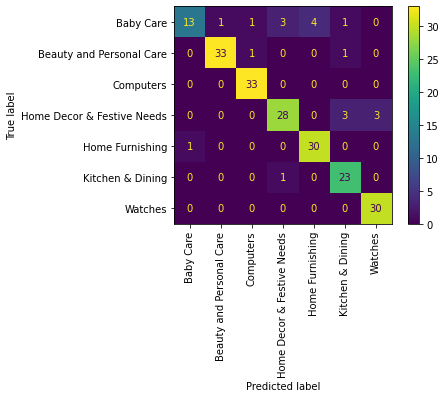

In [65]:
cm_mnb = confusion_matrix(y_test, y_pred_mnb, labels=mnb.classes_)
disp_mnb = ConfusionMatrixDisplay(confusion_matrix=cm_mnb, display_labels=mnb.classes_)
ax = disp_mnb.plot(xticks_rotation=90)
plt.savefig("cm_mnb.png", bbox_inches="tight", transparence=True)
plt.show()

#### Support Vector Classifier (SVC)

In [66]:
params = {'C': [0.01, 0.1, 0.5, 0.9, 1, 1.1],
          'gamma': ['scale', 'auto'],
          'decision_function_shape': ['ovo', 'ovr']}

In [67]:
svc = GridSearchCV(SVC(), param_grid=params, cv=5)

In [68]:
svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 1.1],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto']})

In [69]:
svc.best_estimator_

SVC(C=1.1, decision_function_shape='ovo')

In [70]:
svc.classes_

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [71]:
y_pred_svc = svc.best_estimator_.predict(X_test)

In [72]:
print('accuracy sur jeu train : ', accuracy_score(svc.best_estimator_.predict(X_train), y_train))
print('accuracy sur jeu test : ', 
      accuracy_score(svc.best_estimator_.predict(
          (X_test)), y_test))

accuracy sur jeu train :  0.9988095238095238
accuracy sur jeu test :  0.919047619047619


In [73]:
print(classification_report(y_test, y_pred_svc, target_names=svc.classes_))

                            precision    recall  f1-score   support

                 Baby Care       0.93      0.57      0.70        23
  Beauty and Personal Care       0.97      0.97      0.97        35
                 Computers       0.94      1.00      0.97        33
Home Decor & Festive Needs       0.84      0.91      0.87        34
           Home Furnishing       0.88      0.97      0.92        31
          Kitchen & Dining       0.92      0.92      0.92        24
                   Watches       0.97      1.00      0.98        30

                  accuracy                           0.92       210
                 macro avg       0.92      0.90      0.91       210
              weighted avg       0.92      0.92      0.91       210



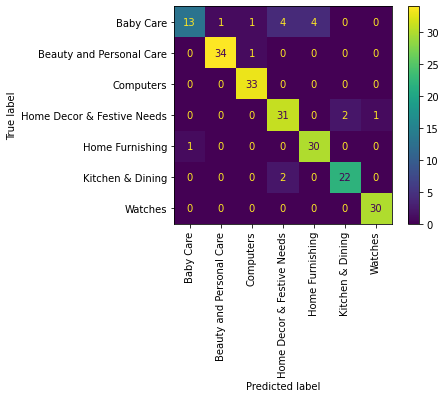

In [74]:
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=svc.classes_)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc.classes_)
ax = disp_svc.plot(xticks_rotation=90)
plt.savefig("cm_svc.png", bbox_inches="tight", transparence=True)
plt.show()

#### MLPClassifier(Neural Network)

In [75]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

MLPClassifier()

In [76]:
y_pred_mlp = mlp.predict(X_test)

In [77]:
print('accuracy sur jeu train : ', accuracy_score(mlp.predict(X_train), y_train))
print('accuracy sur jeu test : ', accuracy_score(mlp.predict(X_test), y_test))

accuracy sur jeu train :  1.0
accuracy sur jeu test :  0.9095238095238095


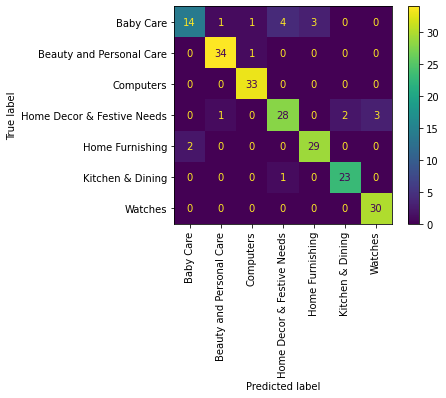

In [78]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=mlp.classes_)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=mlp.classes_)
ax = disp_mlp.plot(xticks_rotation=90)
plt.savefig("cm_mlp.png", bbox_inches="tight", transparence=True)
plt.show()

In [79]:
print(classification_report(y_test, y_pred_mlp, target_names=mlp.classes_))

                            precision    recall  f1-score   support

                 Baby Care       0.88      0.61      0.72        23
  Beauty and Personal Care       0.94      0.97      0.96        35
                 Computers       0.94      1.00      0.97        33
Home Decor & Festive Needs       0.85      0.82      0.84        34
           Home Furnishing       0.91      0.94      0.92        31
          Kitchen & Dining       0.92      0.96      0.94        24
                   Watches       0.91      1.00      0.95        30

                  accuracy                           0.91       210
                 macro avg       0.91      0.90      0.90       210
              weighted avg       0.91      0.91      0.91       210



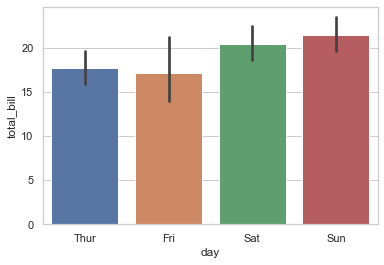

In [98]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="day", y="total_bill", data=tips)

In [99]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
